## Multi-class calssification

### 기본 세팅

In [2]:
from google.colab import drive
drive.mount('/content/data') # 드라이브 연결

Mounted at /content/data


In [3]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

plt.ion()
# Check PyTorch version
torch.__version__

'2.0.0+cu118'

In [4]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [5]:
# class 데이터 만들때 , class 파라미터에 사용
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

### 기본 과정 전처리

In [6]:
# 1.데이터 만들기
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED)

In [7]:
# 2.type 변환
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5],y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [8]:
# 3,split
X_blob_train , X_blob_test , y_blob_train , y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

In [9]:
# 4.shape 확인
X_blob_train.shape , X_blob_test.shape , y_blob_train.shape , y_blob_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

### model 만들기

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#### 설계도

In [11]:
from torch import nn
class BlobModel(nn.Module):
  def __init__(self , input_features , output_features , hidden_units=8):


    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self , x):
    return self.linear_layer_stack(x)

#### 모델

In [12]:
model_4 = BlobModel(input_features=NUM_FEATURES, # input shape 2
                    output_features=NUM_CLASSES, # output shape 4
                    hidden_units=8).to(device)   # 가운데 hidden 8

### testing loop

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [14]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,y_pred=y_pred)

    # backpropagation#

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.93045, Acc: 24.12% | Test Loss: 0.91191, Test Acc: 49.00%
Epoch: 10 | Loss: 0.20672, Acc: 98.62% | Test Loss: 0.17862, Test Acc: 99.50%
Epoch: 20 | Loss: 0.09828, Acc: 99.00% | Test Loss: 0.08866, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06784, Acc: 99.00% | Test Loss: 0.05968, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05422, Acc: 99.12% | Test Loss: 0.04621, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04668, Acc: 99.12% | Test Loss: 0.03857, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04195, Acc: 99.12% | Test Loss: 0.03369, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03875, Acc: 99.12% | Test Loss: 0.03032, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03644, Acc: 99.12% | Test Loss: 0.02786, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03471, Acc: 99.12% | Test Loss: 0.02598, Test Acc: 99.50%


In [20]:
print(f'prediction:{y_pred[:5]} , test:{y_blob_test[:5]}')
print( accuracy_fn(y_true=y_blob_train,y_pred=y_pred))

prediction:tensor([1, 0, 2, 2, 0]) , test:tensor([1, 3, 2, 1, 0])
99.125


NameError: ignored

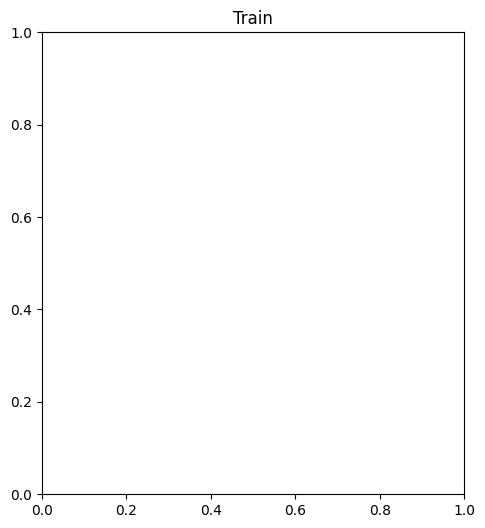

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)